# Project: Anti-Refugee Tweet Classification using Sentiment Analysis
---
### Goal: Predict whether a given tweet is Pro-Refugee or Anti-Refugee.
---

Today, we will be building on our earlier insights about models to build more sophisticated models that take into account the semantics of the words in our tweets–not just their counts.

## Imports

Run the below cells to get started–this will take a minute.

In [ ]:
#@title Run this to import all the necessary packages { display-mode: "form" }
import json
import tweepy
from datetime import datetime, timedelta
import re
import numpy as np
import random
import json
import math
from collections import Counter
import matplotlib.pyplot as plt
import os
import sys
import pandas

import nltk
nltk.download('punkt', quiet=True)
from nltk.tokenize import TweetTokenizer, sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords' ,quiet=True)

from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input


import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import warnings
warnings.filterwarnings('ignore')

import gdown
import zipfile
import shutil

gdown.download('https://drive.google.com/uc?id=1ifYLZ-19ZyjjRUICe4PDRmZFAkyL73d0','./source_data.zip',True)
my_zip = zipfile.ZipFile('./source_data.zip', mode = 'r')
my_zip.extractall()
basepath = './drive/Team Drives/Inspirit Curriculum/Inspirit AI Program/Working Materials/Tejit\'s Material/Anti-Refugee Sentiment Analysis'
shutil.move('./Anti-Refugee Sentiment Analysis/', basepath)

module_folder = './drive/Team Drives/Inspirit Curriculum/Inspirit AI Program/Working Materials/Tejit\'s Material/Anti-Refugee Sentiment Analysis/'

if module_folder not in sys.path: sys.path.append(module_folder)
import lib
from lib import Tweet
from lib import Tweet_counts

# # If the above doesn't work, then upload the file!
# from google.colab import files
# src = list(files.upload().values())[0]
# open('lib.py','wb').write(src)
# import lib
# from lib import Tweet
# from lib import Tweet_counts

In [ ]:
#@title Run this to read the data from data.json and split in train and test { display-mode: "form" }
file_name = 'data.json'
dir_name = 'Data'
file_path = os.path.join(basepath, dir_name, file_name)
data = lib.read_json(file_path, shuffle=True, remove_words = set(stopwords.words('english')))
train, test = train_test_split(data, test_size=0.1)

Total number of unique tweets read are: 635


# Milestone 1: Word2Vec Model

## Introduction - Word2Vec

### Disadvantage of One-Hot-Encoding

Previously, we covered Bag of Words and Tfidf that is encoding words as vectors in a matrix. We did this because we cannot pass the words directly into a model and hence required some sort of numerical representations for words. However, there are some disadvantages of using these vectors as a method to encode words. The two main ones are:

1. They are too sparse, given a large corpus. A corpus is the vocabulary of words in a text. If there are way too many words in the text, then the length of the matrix in a one hot encoding representation is too large, with many 0's in the matrix. This makes it difficult to store and possibly computationally too expensive to work with.

2. These encodings do not encode semantics. Semantics is the branch of linguistics concerned with meaning. If we use one hot encoding, we don't have any information about the meaning of the words in the sentences, which can be defined by its placement in the sentence. For instance, the meaning of the word 'laid' in the two tweets is quite antithetical:

> Tweet 1: He laid the foundation to peace #refugeeswelcome<br>
> Category: False

> Tweet 2: Shot by the thief, the refugee laid on the floor <br>
> Category: True


You can see why these sparse encodings are not the best method to procceed with. They provide us with a good representation of the tweets and a good basic model, however, we need much more sophisticated models, which can encoding meanings of the words as well.

This is where word embeddings comes into play.

### Word2Vec Model:

#### Introduction

 **Word Embeddings** are a language modeling technique used for mapping words to vectors of real numbers such that semantically similar words have similar vectors. Note that vectors and embeddings are terms often used interchangeably here.

The main difference between an embedding vector and a one hot encoded vector is that it is *dense*, i.e. there are no zeroes in the vector. In the previous notebook we saw that the word vector for a single word (whether using Bag of Words or Tfidf for a sentence) was always a one hot encoding, and that it consisted entirely of zeros except for a one in the index of where the word shows up in the vocabulary.
This means that every word can be considered to have a "meaning" that is entirely independent of all the other words. However we know that this is not true for actual language.

At a high level, word embeddings are able to infer the "meaning" of words by being trained on a large body of text so that words that co-occur (occur near each other) with similar words have similar embeddings. For example, "good" and "great" show up near similar words, and so we'd expect them to have similar embeddings. 

If you're interested in further details of how these work, [read this optional article](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa).



#### Exercise (Discussion)

Based on the knowledge that you gathered about the Word2Vec model, explain why it might perform better than Bag of words or Tfidf model for anti-refugee sentiment (or any NLP application for that matter)

### Understanding Word Vectors using *Alice in Wonderland*

To train some of our own embeddings, let us (briefly) forget about anti-refugee sentiment and consider the story of *Alice in Wonderland* as our document.


In [ ]:
#@title Run this cell to download all of Alice in Wonderland!
def get_alice_data(file_path):
    file = open(file_path, 'r')
    text = file.read()
    text.replace('\n', ' ')
    data = []
    for i in sent_tokenize(text):
        temp = []
        for j in word_tokenize(i): temp.append(j.lower())
        data.append(temp)
    return data

file_name = 'alice.txt'
file_path = os.path.join(basepath, file_name)
alice_data = get_alice_data(file_path)

`alice_data` contains the entire text of *Alice in Wonderland*. Here specifically, it is a list of tokens, i.e. it is a list of all the sentences in *Alice in Wonderland*, and each individual sentence has been tokenized. So `alice_data` is ultimately a list of lists.

Change the value of the index in the cell below to see some of these sentences.

In [ ]:
alice_data[100]

['oh', 'dear', ',', 'what', 'nonsense', 'i', "'m", 'talking', '!', "'"]

Now, we will train word vectors from our Alice in Wonderland text. That is, our model will only have knowledge of the English language from whatever we pass into it from `alice_data`. 

In [ ]:
embedding_model = Word2Vec(alice_data, min_count=1, window=5, hs=1)

In [ ]:
embedding_model.wv['on'].size

100

The `window` parameter here is the number of words to be selected on either side of the chosen word (the context that determines the numbers in that vector). The `min_count` parameter removes all words that are less that the given count, 1 for instance over here. The details of the `hs` parameter are too advanced for this introductory AI course, suffice to say that by setting it to 1 we allow our models to learn useful representations of words.

In [ ]:
#@title Word embedding similarities { vertical-output: true, display-mode: "form" }
word1 = "green" #@param {type:'string'}
word2 = "grass" #@param {type:'string'}

print("Similarity between "+word1+" and "+word2+": {:.2f}".format(embedding_model.wv.similarity(word1,word2)))


Similarity between green and grass: 0.92


We can see some fairly high similarities between words. You can also try to modify the `min_count` and `window` parameter values and retrain the model to see if that affects any word similarities.


#### Discussion

Are there any pairs of words that seem to have a higher or lower similarity than you would expect? Why do you think that is the case?

In [ ]:
'''
YOUR ANSWER HERE
'''

We trained our word vectors on a specific piece of text from which it learned what certain words mean. However to gain an understanding of the universal meaning of words training them on larger pieces of text is better.

# Milestone 2: Word2Vec Pre-trained models

## Word2Vec Model 1: Pre-trained Google Model

### Model

Let us examine a pretrained Word2Vec model by Google. The below cell will take about 5 min to run, so be patient!

In [ ]:
#@title Run this to load the model { vertical-output: true, display-mode: "form" }
#@markdown The model will take long to load, so do not cancel the process.
%%time
import zipfile, io, requests
print('Downloading...')
# Download class resources...
r = requests.get("https://www.dropbox.com/s/uq9w6e93gccd152/google_news.zip?dl=1")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
print('Loading downloaded files...')
file_name = 'GoogleNews-vectors-negative300.bin'
dir_name = 'google_news'
file_path = os.path.join(dir_name, file_name)
model1 = KeyedVectors.load_word2vec_format(file_path, binary=True)
model1.init_sims(replace=True)

Downloading...
Loading downloaded files...
CPU times: user 1min 36s, sys: 15.1 s, total: 1min 51s
Wall time: 3min 10s


You can see that the array representation of the same word from our pretrained model is much larger than that from our cbow or skip-gram models. This means that our pretrained model contains more *semantic richness* than our quickly trained model on *Alice in Wonderland*. 

In [ ]:
#@title Run to see the lengths of vectors compared between models
print("Length of pretrained model word vectors: " + str(len(model1.get_vector("house"))))
print("Length of word vectors trained by us: " + str(len(embedding_model.wv.get_vector("house")))) 

Length of pretrained model word vectors: 300
Length of word vectors trained by us: 100


Now try changing the words in the interactive cell below to see the similarity between different words. See if these similarities make more sense!

In [ ]:
#@title Word embedding similarities { vertical-output: true, display-mode: "form" }
word1 = "red" #@param {type:'string'}
word2 = "crimson" #@param {type:'string'}

print("Similarity between "+word1+" and "+word2+": {:.2f}".format(model1.wv.similarity(word1,word2)))

Similarity between red and crimson: 0.58


We can actually see what words each of our models thinks is most similar to a given word. The model trained on Alice in Wonderland may give you some strange results!

In [ ]:
#@title Most similar words in different models
comparison_word = 'cat'#@param {type: 'string'}
alice_words = embedding_model.similar_by_word(comparison_word)
full_words = model1.similar_by_word(comparison_word)
print("MOST SIMILAR WORDS FROM MODEL TRAINED ON ALICE IN WONDERLAND")
for i in alice_words:
  print(i[0])
  
print("MOST SIMILAR WORDS FROM MODEL TRAINED ON GOOGLE NEWS")
for i in full_words:
  print(i[0])


MOST SIMILAR WORDS FROM MODEL TRAINED ON ALICE IN WONDERLAND
talking
course
'yes
meaning
'i
ready
porpoise
getting
offended
'm
MOST SIMILAR WORDS FROM MODEL TRAINED ON GOOGLE NEWS
cats
dog
kitten
feline
beagle
puppy
pup
pet
felines
chihuahua


#### Setting up the data

Now that we have the model in place, let us return to our problem of Tweet anti-refugee sentiment analysis.

We can make a list of tokenLists of all training and testing tweets (similar to the list of tokenized sentences from Alice in Wonderland), and also a list of the categories of the training and testing tweets.

In [ ]:
train_tokenized = []
train_tweet_label = []
for t in train:
  train_tokenized.append(t.tokenList) # this is x_train
  train_tweet_label.append(t.category) # this is y_train

test_tokenized = []
test_tweet_label = []
for t in test:
  test_tokenized.append(t.tokenList) # this is x_test 
  test_tweet_label.append(t.category) # this is y_test

### Sentence Embeddings

So far we have discussed how to get the meaning of individual words as dense vectors. How would one step that up to get the meaning of a sentence, or a tweet, from these vectors?

One way is to simply add all the vectors in a sentence together and divide by the length of the vector. This creates an "average" of all the word vectors in the sentence together.

For example, if we have three embedding vectors in our sentence with the values 

`[1 7 3]`  `[2 2 2]` `[3 1 3]`

Then our average sentence vector will be `[2 3.33 2.67]`.

The `word_averaging_list(model, tokenizedList)` method from the lib file does this for us. 

The method uses the trained model and the tokenized input from a list to convert the Tweet to dense vector form using the model. This input, converted, can then be used for prediction or testing. The method takes the model and the list of tokens as the parameter. 

We need to convert both our test and train data to these dense vectors for each model.


```



In [ ]:
word2vec_train = lib.word_averaging_list(model1,train_tokenized)
word2vec_test = lib.word_averaging_list(model1,test_tokenized)

The cell below shows us what one of these dense vectors looks like.

In [ ]:
word2vec_train[0]

array([-0.05240037,  0.05812327, -0.02199082,  0.09079961, -0.00912755,
       -0.0213754 ,  0.0073995 , -0.07151303,  0.01555777,  0.04452036,
       -0.0464788 , -0.13087013, -0.00986861,  0.07517771, -0.08234611,
        0.10848299,  0.07981247,  0.13648252,  0.04324709, -0.03791617,
        0.0301124 ,  0.0254908 ,  0.08625544,  0.01739423,  0.14157361,
        0.0189876 , -0.0544249 , -0.04449974,  0.01741578, -0.090001  ,
       -0.01486013,  0.01701555,  0.0011399 ,  0.00788036,  0.02955163,
        0.0211152 ,  0.02558886,  0.03555361,  0.01488241,  0.01644401,
        0.13429885, -0.01448205,  0.11589498, -0.01505876, -0.04160787,
       -0.03573069, -0.10899768, -0.01976457, -0.0090813 ,  0.06748169,
        0.02429601,  0.03884685, -0.00935784,  0.06088878,  0.05445455,
        0.05046721, -0.08344578, -0.05054331,  0.03654719, -0.10010935,
       -0.09494709,  0.10158836, -0.14050725, -0.057026  ,  0.04732022,
       -0.06388194,  0.00282979,  0.02897251, -0.09681907,  0.05

Now, we will run logistic regression on this transformed input. Instead of calling from `sklearn`, we have made a concise function in the lib package for you guys! 

You can call the logistic regression function this way:

> `logistic_model(train_data, train_labels, test_data, test_labels)`

and it takes the following parameters:

> train_data: the training vectors or data, this would go in the logistic regression model's fit function directly <br>
> train_labels: the training data's labels <br>
> test_data: the testing vectors or data, this would go in the logistic regression model's predict function directly <br>
> test_labels: the test data's labels

and it returns the predicted labels and the confusion matrix.

In this case, we would use it this way:

In [ ]:
predicted1, matrix1 = lib.logistic_model(word2vec_train, train_tweet_label, word2vec_test, test_tweet_label)
predicted1

array([ True, False,  True,  True, False, False,  True, False,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False,  True, False, False,  True,  True, False,  True, False,
       False, False,  True,  True,  True, False,  True, False,  True,
        True, False, False, False,  True, False, False, False,  True,
        True,  True,  True, False, False,  True,  True, False,  True,
        True])

To show the confusion matrix, use the method `disp_confusion_matrix(matrix)` from the lib package, like so:

       True   False
True      23      7
False      9     25


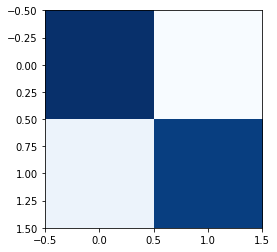

In [ ]:
lib.disp_confusion_matrix(matrix1)

To see stats for this prediction, you can use `model_stats(matrix)` method from the lib file. The method takes the confusion matrix as an argument and prints the number of correct and incorrect tweets and the accuracy of the model

In [ ]:
lib.model_stats(matrix1, to_print=True)

The total number of correct predictions are: 48
The total number of incorrect predictions are: 16
Accuracy on the test data is: 75.00%


Great! This model is pretty accurate.

Let us also look at the tweets this model classified incorrectly.

In [ ]:
print('{:^125}|{:^10}|{:^7}'.format('Tweet','Category','Result'))
for i in range(len(test)):
  if test_tweet_label[i] != predicted1[i]:
    print('{:<125}|{:^10}|{:^7}'.format(str(test[i]), test_tweet_label[i], predicted1[i]))

                                                            Tweet                                                            | Category |Result 
yes carrying home heart dvpit                                                                                                |    0     |   1   
knew would happen one reason nevertrump                                                                                      |    0     |   1   
every refugee term use forced upon communities che                                                                           |    1     |   0   
two aftermaths refugee crime cases sweden via                                                                                |    1     |   0   
2012-2014 refugee breakdown state altright maga refugeesnotwelcome greatreplacement rapefugees banislam                      |    1     |   0   
refugee crimes area country                                                                                                  |    

### Exercise (Discussion)

Why do you think the tweets above were classified incorrectly?

In [ ]:
'''
idk maybe they share more similarities w the other category
'''

## Word2Vec Model2 : Pre-trained Twitter Model

### Setting up model

The best way forward in practice is to train word vectors on the text data relevant to whichever specific problem you are studying. Ideally training these dense vectors on the relevant text allows the word vectors to pick up whatever nuances are present in that data already present.

This following model has been trained on our specific dataset of refugee-related Tweets. Hence, logically, it should be better than the previously trained model! Run the below cell to load it.

In [ ]:
#@title Setting up model2 { vertical-output: true, display-mode: "form" }
#@markdown >Setting up the model might take time. <br> <br>
#@markdown >You can access the model as model2
%%time
file_name = 'word2vec_model_twitter.txt'
dir_name = 'Word2Vec_models'
file_path = os.path.join(basepath, dir_name, file_name)
model2 = KeyedVectors.load_word2vec_format(file_path, binary=False) # binary will be false in case of text files
model2.init_sims(replace=True)

CPU times: user 2min 10s, sys: 2.88 s, total: 2min 13s
Wall time: 2min 13s


### Twitter Model Predicting - Exercise (Coding)

The way you prepare the data and make the predictions for this model is the same as the previous model. In case you get confused, refer above

Applying the model on train and test tokens:

In [ ]:
### Your code goes here ###

# word2vec_train2 = use lib.word_averaging_list with the arguments model2 and train_tokenized (in the same order)
# word2vec_test2 = use lib.word_averaging_list with the arguments model2 and test_tokenized (in the same order)
word2vec_train2 = lib.word_averaging_list(model2,train_tokenized)
word2vec_test2 = lib.word_averaging_list(model2,test_tokenized)

### Your code ends here ###



### Twitter Model Prediction

If all went well, the below code should evaluate your model:

[False False False  True False False  True False  True  True False False
 False  True  True  True  True  True  True  True False False False False
 False False False False  True False False  True  True False  True False
 False False False  True  True False  True False  True False False False
  True  True False False False  True False  True  True False False  True
  True False  True False]
The total number of correct predictions are: 47
The total number of incorrect predictions are: 17
Accuracy on the test data is: 73.44%
       True   False
True      25      5
False     12     22


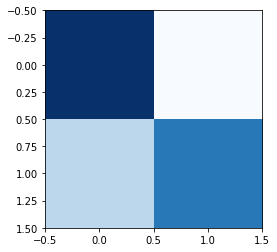

In [ ]:
predicted2, matrix2 = lib.logistic_model(word2vec_train2, train_tweet_label, word2vec_test2, test_tweet_label)
print(predicted2)
lib.model_stats(matrix2, to_print=True)
lib.disp_confusion_matrix(matrix2)

Let us also look at the tweets this model classified incorrectly

In [ ]:
print('{:^125}|{:^10}|{:^7}'.format('Tweet','Category','Result'))
for i in range(len(test)):
  if test_tweet_label[i] != predicted2[i]:
    print('{:<125}|{:^10}|{:^7}'.format(str(test[i]), test_tweet_label[i], predicted2[i]))

                                                            Tweet                                                            | Category |Result 
germany 82 year-old woman tortured death syrian child refugee                                                                |    1     |   0   
believe muslim molesting manikin nothing sacred quality refugee                                                              |    1     |   0   
yes carrying home heart dvpit                                                                                                |    0     |   1   
knew would happen one reason nevertrump                                                                                      |    0     |   1   
every refugee term use forced upon communities che                                                                           |    1     |   0   
two aftermaths refugee crime cases sweden via                                                                                |    

### Exercise (Discussion)

Why do you think the tweets above were classified incorrectly?

## Word2Vec Models: Model Comparison

### Exercise (Discussion)

Why do you think one model was better than the other?

In [ ]:
'''
YOUR ANSWER HERE
'''

## Conclusion

Congratulations on completing the notebook for this project! Although we have gone deep into specifics of what types of representations work best for words, we are still trying to solve a real world problem. From the text data we have, and with basic classification models, we cannot classify anti-refugee tweets from pro refugee tweets with a higher accuracy than about 82-83%. Detecting the true meaning, or the intention of what someone is saying involves a lot more information than just the words they use. 

The best way to determine someone's true intention is to assess the context in which they say something. In the case of anti-refugee Tweets, in order to better classify a Tweet, we would need information about the user as well. Their previous Tweets, their followers, the other users they follow, and their location may give us some indication of their true interests and their political leanings, and thereby help to tell us whether a particular Tweet truly does express anti-refugee sentiment (or any kind of hate speech). 

This is not an easy problem to solve. Big tech companies are trying their best to help as much as they can, but in the end this is an expression of issues that are deeper than technology and social media. The main fixes to these expressions of anti-refugee sentiment will be geopolitical and humanitarian in nature.